In [1]:
#This notebook is for creating the plots from the publication

In [2]:
#imports
import sys

sys.path.append("./covid19_inference")
import covid19_inference as cov19

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter,WeekdayLocator
import matplotlib
import pandas as pd
import numpy as np

In [3]:
## Overview figure


In [4]:
cmap =  matplotlib.cm.get_cmap('Blues')

colors = {}
colors["B.1.1"] = "#648fff"
colors["B.1.1.348"] = "#ffb000"
colors["B.1.1.7"] = "#dc267f"
colors["C.37"] = "#fe6100"
colors["P.1"] = "#785ef0"
colors["unknown"] = "#D55E00"
colors["Total"] = "#000000"

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local
<ipython-input-5-b1943318bf00>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=30)


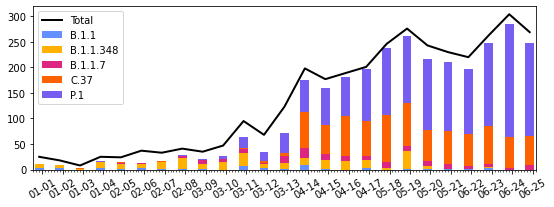

In [5]:
# Load data variants
variants = pd.read_excel("./data/Chile_Variants_Updated_with_airports.xlsx",sheet_name="Variants_Count")
variants = variants.set_index('Lineage').T
variants.index.name = "Week"
variants.index = pd.to_datetime(variants.index + '-1', format='%V_%G-%u')
variants = variants.iloc[0:-1]
variant_names = ["B.1.1", "B.1.1.348", "B.1.1.7", "C.37", "P.1", "unknown"]

# Load casenumbers chile and sum over weeks
jhu = cov19.data_retrieval.JHU(True)
new_cases_obs = jhu.get_new(country="Chile",data_begin=variants.index[0],data_end=variants.index[-1])

"""# Plot data
"""
fig, ax = plt.subplots(1,1,figsize=(9,3))

# Barplots
s=0
for c in variants.columns:
    if c == "N_Total":
        continue
    ax.bar(variants.index,variants[c],width=3,label=c,bottom=s,color=colors[c])
    s += variants[c]
    
# Total
ax = cov19.plot._timeseries(
    x=variants.index,
    y=variants["N_Total"],
    what="model",
    color="black",
    ax=ax,
    label="Total",
    lw=2
)
ax.legend()
date_form = DateFormatter("%m-%V")


ax.set_xticklabels(ax.get_xticks(), rotation=30)
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(WeekdayLocator(interval=1))
_ = ax.set_xlim(variants.index[0]-timedelta(days=2), variants.index[-1]+timedelta(days=2))

fig.savefig("figures/0_overview.png",dpi=300)
fig.savefig("figures/0_overview.pdf",dpi=300)

In [6]:
## Casenumber with model fit

In [7]:
""" Load model run
Please run the model if you haven't !
"""
likelihood="dirichlet"
spreading_dynamics="kernelized_spread"
influx_factor=0.2

postfix_for_plots=f"_influx={influx_factor}"

import pickle
with open(f"./pickled/Variants-likelihood={likelihood}-spread_method={spreading_dynamics}-influx={influx_factor}.pickle", "rb") as f:
    model, trace = pickle.load(f)
    
""" Easy plot timeseries function
"""
def plot_timeseries(trace, model, key, var=None, ax=None, **kwargs):
    # Get data
    if var is None:
        var = np.array(trace.posterior[key])
        var = var.reshape((var.shape[0]*var.shape[1],) + var.shape[2:])
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(16,8))

    axes = cov19.plot._timeseries(
        x=pd.date_range(this_model.sim_begin,this_model.sim_end),
        y=var[:,:],
        what="model",
        ax=ax,
        **kwargs
    )
    return axes

def posterior_to_array(trace, key):
    """
    Convert posterior for a key into a numpy array. Flattens
    chain and draw dimension.
    """
    var = np.array(trace.posterior[key])
    var = var.reshape((var.shape[0]*var.shape[1],) + var.shape[2:])
    return var


<ipython-input-8-3e10ee776bf6>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=30)


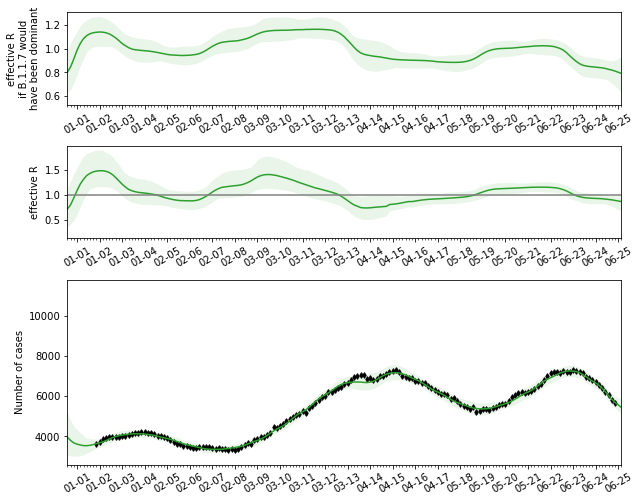

In [8]:
""" Plot lambda and casenumbers
"""
fig, axes = plt.subplots(3,1,figsize=(9,7), gridspec_kw={'height_ratios': [1, 1, 2]})
date_range = pd.date_range(model.sim_begin, model.sim_end)

# Plot R value (or lambda depending on the model)
R = posterior_to_array(trace,"base_lambda_t")
cov19.plot._timeseries(
    x=date_range,
    y=R,
    what="model",
    ax=axes[0]
)
axes[0].set_ylabel("effective R\nif B.1.1.7 would\nhave been dominant")

R = posterior_to_array(trace,"base_lambda_t")
f = posterior_to_array(trace,"f_v")
unkn = posterior_to_array(trace,"unknown_lambda_t")
new_I = posterior_to_array(trace,"new_I_tv")
tau_spread = new_I/np.sum(new_I, axis=-1)[...,None]
S_t = posterior_to_array(trace,"S_t")
fact = S_t/model.N_population
R_eff = np.exp(np.sum(np.log(R[:,:,None]*f[:,None,:])*fact[...,None]*tau_spread[:,:,:-1] + (np.log(unkn*R)*fact*tau_spread[:,:,-1])[:,:,None], axis=-1))


cov19.plot._timeseries(
    x=date_range,
    y=R_eff,
    what="model",
    ax=axes[1]
)
axes[1].set_ylabel("effective R")
axes[1].plot(date_range, np.ones(len(date_range)), color='grey')


# Calculate rolling average new_cases
nc = posterior_to_array(trace,"new_cases")
nc = pd.DataFrame(nc.T,index=pd.date_range(model.sim_begin,model.sim_end))


# Plot new cases (real)
cov19.plot._timeseries(
    x=new_cases_obs.index[7:],
    y=new_cases_obs.rolling(7).mean().T[7:],
    what="data",
    ax=axes[2],
    color="black",
    markersize=4
)
# Plot new cases (model)
cov19.plot._timeseries(
    x=nc.index,
    y=nc.rolling(7).mean().T,
    what="model",
    ax=axes[2]
)
axes[2].set_ylabel("Number of cases")


for ax in axes:
    ax.set_xticklabels(ax.get_xticks(), rotation=30)
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(WeekdayLocator(interval=1))
    # exclude first 7 days because of the rolling window of cases of 7 days
    _ = ax.set_xlim(model.data_begin-timedelta(days=2), model.data_end+timedelta(days=2))
    
fig.tight_layout()
fig.savefig(f"./figures/1_lambda+cases{postfix_for_plots}.png",dpi=300)
fig.savefig(f"./figures/1_lambda+cases{postfix_for_plots}.pdf",dpi=300)

In [9]:
## Influx

<ipython-input-10-c5be5019faae>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=30)


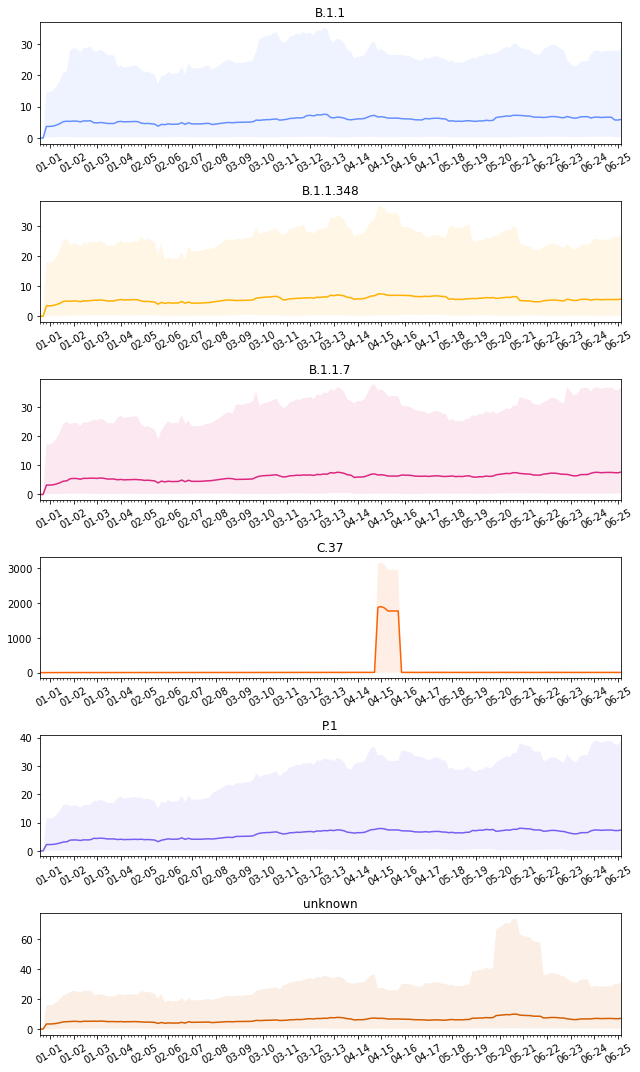

In [10]:
fig, axes = plt.subplots(6,1,figsize=(9,3*5))
Phi = posterior_to_array(trace,"Phi")

for v, v_name in enumerate(variant_names):
    cov19.plot._timeseries(
        x = pd.date_range(model.sim_begin,model.sim_end),
        y = Phi[:,:,v],
        color=colors[v_name],
        ax=axes[v],
        what="model"
    )

for a,ax in enumerate(axes):
    ax.set_title(variant_names[a])
    ax.set_xticklabels(ax.get_xticks(), rotation=30)
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(WeekdayLocator(interval=1))
    _ = ax.set_xlim(model.data_begin-timedelta(days=2), model.data_end+timedelta(days=2))
fig.tight_layout()

fig.savefig(f"./figures/2_influx{postfix_for_plots}.png",dpi=300)
fig.savefig(f"./figures/2_influx{postfix_for_plots}.pdf",dpi=300)

In [11]:
## Tau

<ipython-input-12-243ec369fa8d>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=30)


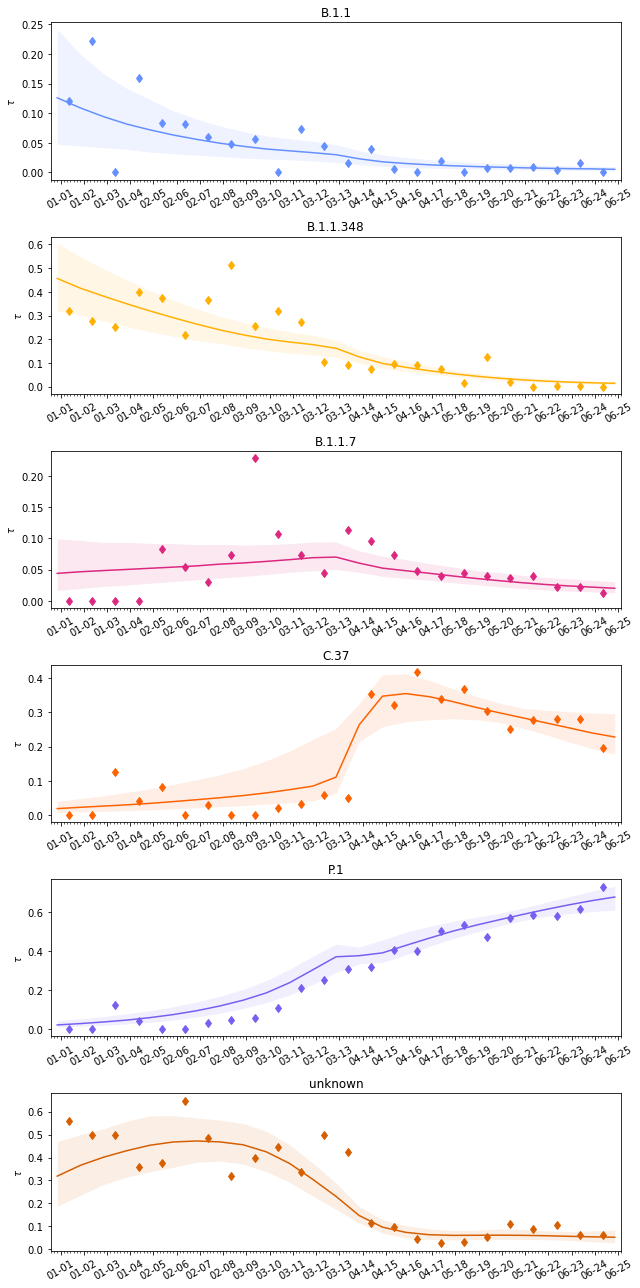

In [12]:
fig, axes = plt.subplots(6,1,figsize=(9,3*6))

for v, variant in enumerate(variant_names):
    ax = cov19.plot._timeseries(
        x=variants.index,
        y=posterior_to_array(trace,"tau_w")[:,:,v],
        what="model",
        ax=axes[v],
        color=colors[variant],
    )
    if v == 5 :
        ax = cov19.plot._timeseries(
            x=variants.index + timedelta(days=3.5),
            y=(variants["N_Total"]-variants[variants.columns[0:5]].sum(axis=1))/variants["N_Total"],
            what="data",
            ax=ax,
            color=colors[variant]
        )       
    else:
        ax = cov19.plot._timeseries(
            x=variants.index + timedelta(days=3.5),
            y=variants[variants.columns[v]]/variants["N_Total"],
            what="data",
            ax=ax,
            color=colors[variant]
        )
    ax.set_title(variant)

for ax in axes:
    ax.set_xticklabels(ax.get_xticks(), rotation=30)
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(WeekdayLocator(interval=1))
    _ = ax.set_xlim(model.data_begin-timedelta(days=2), model.data_end+timedelta(days=2))
    
    # 
    ax.set_ylabel(r"$\tau$")
fig.tight_layout()
fig.savefig(f"./figures/3_tau{postfix_for_plots}.png",dpi=300)
fig.savefig(f"./figures/3_tau{postfix_for_plots}.pdf",dpi=300)

In [13]:
## f factor

/data.nst/jdehning/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(


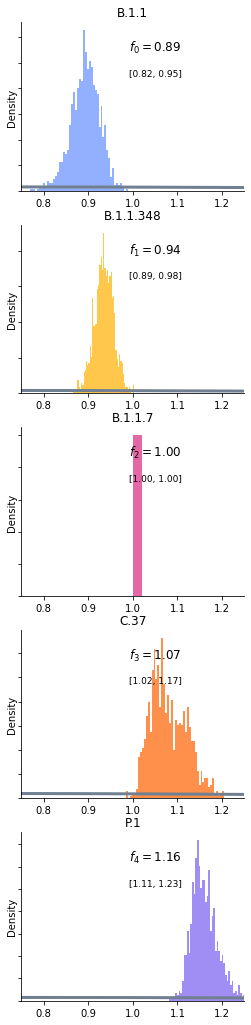

In [14]:
import plot as pl
from rcParams import *
import pymc3 as pm

fig, axes = plt.subplots(5,1,figsize=(4,3*6))

# Get data from trace and sample prior
f = posterior_to_array(trace,"f_v")
prior_f = pm.sample_prior_predictive(
    samples=1000, model=model, var_names=["f_v"]
)["f_v"]

fixed = "B.1.1.7"
off = 0 # offset

for v, variant in enumerate(variant_names[:-1]):
    axes[v].set_xlim(0.75,1.25)
    rcParams.color_posterior = colors[variant]
    pl._distribution(
        array_posterior=f[:, v] if not variant == fixed else 1,
        array_prior=prior_f[:, v] if not variant == fixed else None,
        dist_name="f_v",
        dist_math="f",
        suffix=f"{v}",
        ax=axes[v],
    )
    axes[v-off].set_title(variant)
    axes[v-off].set_ylabel("Density")

fig.savefig(f"./figures/4_f{postfix_for_plots}.png",dpi=300)
fig.savefig(f"./figures/4_f{postfix_for_plots}.pdf",dpi=300)

# 